In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
from tqdm import tqdm
from keras_visualizer import visualizer 

In [2]:
data_dir =r"C:\Users\Lerishia\Desktop\The Beam Project\BeamImages"
CATEGORIES = ["GB", "VL1","VL2","VL3"]

import pathlib
data_dir = pathlib.Path(data_dir)



In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count) # shows how many images all together in dataset

5005


In [4]:
GB = list(data_dir.glob('GB/*'))
#PIL.Image.open(str(GB[0]))

VL1 = list(data_dir.glob('VL1/*'))
#PIL.Image.open(str(VL1[0]))
VL2 = list(data_dir.glob('VL2/*'))
VL3 = list(data_dir.glob('VL3/*'))


In [5]:
#creating dataset
batch_size = 32
img_height = 50
img_width = 50

In [6]:
#creating the training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5005 files belonging to 4 classes.
Using 4004 files for training.


In [7]:
#creating the validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5005 files belonging to 4 classes.
Using 1001 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names) #outputs the classes in the dataset 

['GB', 'VL1', 'VL2', 'VL3']


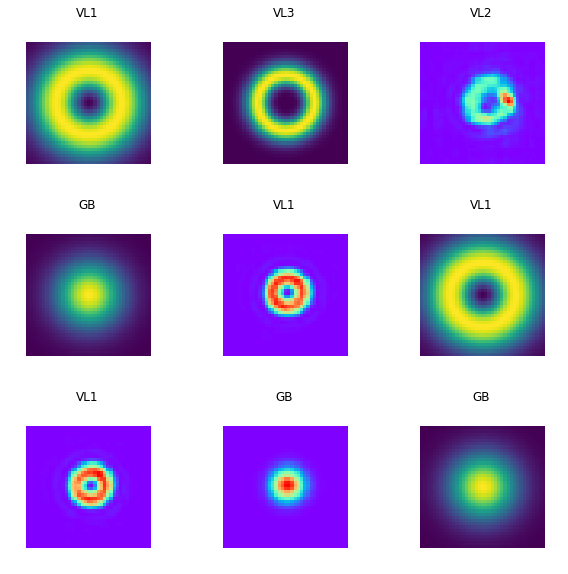

In [9]:
#Visualise the data
import matplotlib.pyplot as plt
#kera is set by default to shuffle the dataset , that is why the sample of nine images are in random order
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

plt.savefig("shuffled training set".format(), dpi=500)

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 50, 50, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
#data.cache is keeping the images in memory after they're loaded off disk during the first epoch.
#This will ensure the dataset does not become a bottleneck while training the model.
#If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#data.prefetch is while training, data preparation and model execution are overlapping.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
#standardizing the data
normalization_layer = layers.Rescaling(1./255)

In [13]:
#standardizing the data
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# pixel values are now in [0,1]
print(np.min(first_image), np.max(first_image))

0.003921569 1.0


In [14]:
#creating the model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes  )
])


In [15]:
#compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#training the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
126/126 [==============================] - 44s 344ms/step - loss: 0.4589 - accuracy: 0.8237 - val_loss: 0.0632 - val_accuracy: 0.9800
Epoch 2/10
126/126 [==============================] - 11s 85ms/step - loss: 0.0411 - accuracy: 0.9855 - val_loss: 0.0349 - val_accuracy: 0.9860
Epoch 3/10
126/126 [==============================] - 11s 89ms/step - loss: 0.0327 - accuracy: 0.9875 - val_loss: 0.0284 - val_accuracy: 0.9860
Epoch 4/10
126/126 [==============================] - 11s 90ms/step - loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.0351 - val_accuracy: 0.9890
Epoch 5/10
126/126 [==============================] - 11s 90ms/step - loss: 0.0262 - accuracy: 0.9905 - val_loss: 0.0437 - val_accuracy: 0.9830
Epoch 6/10
126/126 [==============================] - 11s 90ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 0.0375 - val_accuracy: 0.9840
Epoch 7/10
126/126 [==============================] - 11s 90ms/step - loss: 0.0180 - accuracy: 0.9935 - val_loss: 0.0259 - val_accuracy

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

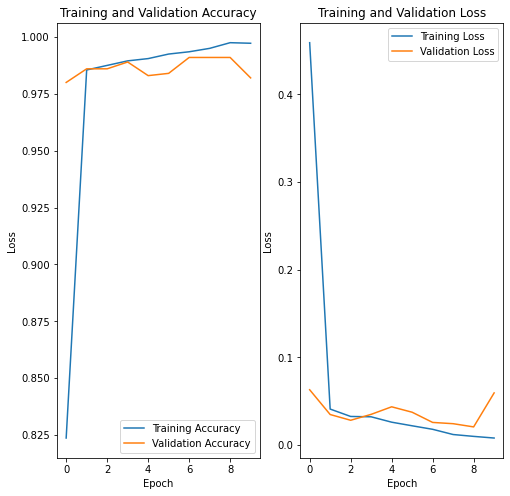

In [17]:
#visualisation after training model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.savefig("first run model analysis acc".format(), dpi=500)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.savefig("first run model analysis loss".format(), dpi=500)
plt.show()


In [18]:
#clearly there is some overfitting hapening
#Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

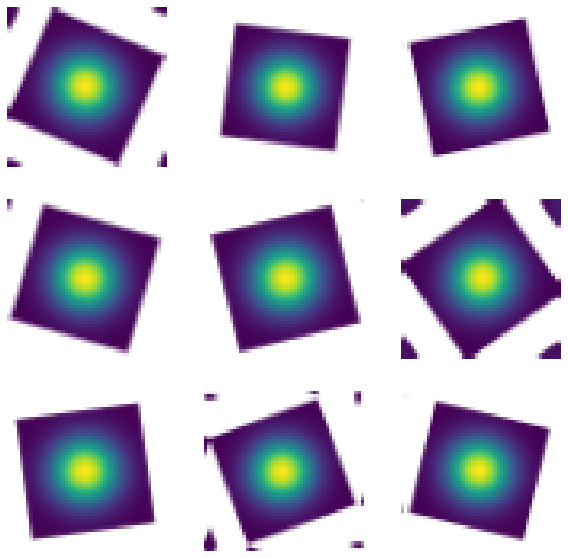

In [19]:
#visualisation of an image going under data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
#modifying the model by dropping out several output units from the layer during the training process
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.1),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.1),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.Dropout(0.3),
  layers.Dense(num_classes)
])

In [21]:
#the model in compiled again
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 50, 50, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

In [23]:
#model is trained again
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
126/126 [==============================] - 14s 103ms/step - loss: 0.3653 - accuracy: 0.8571 - val_loss: 0.0850 - val_accuracy: 0.9730
Epoch 2/10
126/126 [==============================] - 13s 103ms/step - loss: 0.0673 - accuracy: 0.9785 - val_loss: 0.0570 - val_accuracy: 0.9820
Epoch 3/10
126/126 [==============================] - 13s 106ms/step - loss: 0.0474 - accuracy: 0.9843 - val_loss: 0.0307 - val_accuracy: 0.9890
Epoch 4/10
126/126 [==============================] - 13s 107ms/step - loss: 0.0403 - accuracy: 0.9865 - val_loss: 0.0221 - val_accuracy: 0.9890
Epoch 5/10
126/126 [==============================] - 15s 119ms/step - loss: 0.0370 - accuracy: 0.9873 - val_loss: 0.0343 - val_accuracy: 0.9870
Epoch 6/10
126/126 [==============================] - 13s 105ms/step - loss: 0.0328 - accuracy: 0.9893 - val_loss: 0.0221 - val_accuracy: 0.9920
Epoch 7/10
126/126 [==============================] - 13s 103ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0281 - val_ac

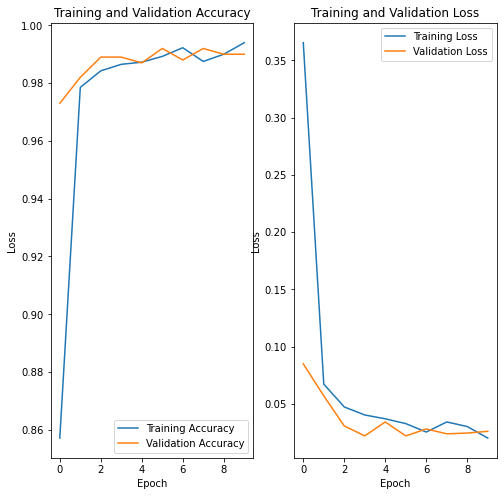

In [24]:
# visualisation of the data after training model after some modifications
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.savefig("second run model analysis acc".format(), dpi=500)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.savefig("second run model analysis loss".format(), dpi=500)
plt.show()

In [25]:
#testing model with unseen data to see if the model is accurate
UnseenBeam_dir=r"C:\Users\Lerishia\Desktop\The Beam Project\UnseenBeamImages"
beam_path = r"C:\Users\Lerishia\Desktop\The Beam Project\UnseenBeamImages\mz3Kg.png"
UnseenBeam_dir= pathlib.Path(UnseenBeam_dir)

img = tf.keras.utils.load_img(
    beam_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} % confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to GB with a 99.57 % confidence.


In [26]:
 acc

[0.8571428656578064,
 0.978521466255188,
 0.9842657446861267,
 0.9865134954452515,
 0.9872627258300781,
 0.989260733127594,
 0.9922577142715454,
 0.987512469291687,
 0.9900099635124207,
 0.9940059781074524]